# Denoising Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
%matplotlib inline

## Setting

In [2]:
# Parameters
transfer_function = tf.nn.sigmoid # tf.nn.relu, tf.nn.softplus, tf.nn.sigmoid, tf.nn.tanh
dropout_probability = 0.9
training_epochs = 10
batch_size = 128
display_step = 1

## data set

In [3]:
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, X_test = mnist.train.images, mnist.test.images
n_samples = int(mnist.train.num_examples)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Help functions

In [4]:
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test

In [5]:
def inverse_transform(X_train_original, X_processed):
    preprocessor = prep.StandardScaler().fit(X_train_original)
    X = preprocessor.inverse_transform(X_processed)
    
    return X

In [6]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    
    return data[start_index:(start_index + batch_size)]

## autoencoder model

In [7]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function=tf.nn.softplus, optimizer=tf.train.AdamOptimizer(),
                 scale=0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.corrupted = self.x + scale * tf.random_normal((n_input,))
        self.hidden = self.transfer(tf.add(tf.matmul(self.corrupted, self.weights['w1']), self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.get_variable("w1", shape=[self.n_input, self.n_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict = {self.x: X,
                                                                            self.scale: self.training_scale
                                                                            })
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X,
                                                     self.scale: self.training_scale
                                                     })

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X,
                                                       self.scale: self.training_scale
                                                       })

    def generate(self, hidden=None):
        if hidden is None:
            hidden = self.sess.run(tf.random_normal([1, self.n_hidden]))
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X,
                                                               self.scale: self.training_scale
                                                               })
    def corrupt(self, X):
        return self.sess.run(self.corrupted, fedd_dict={self.x:X, self.scale: self.training_scale})
    
    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])


class MaskingNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, optimizer = tf.train.AdamOptimizer(),
                 dropout_probability = 0.95, tied_weights=False):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.dropout_probability = dropout_probability
        self.keep_prob = tf.placeholder(tf.float32)
        self.tied_weights = tied_weights

        network_weights = self._initialize_weights(tied=self.tied_weights)
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.corrupted = tf.nn.dropout(self.x, self.keep_prob)
        self.hidden = self.transfer(tf.add(tf.matmul(self.corrupted, self.weights['w1']), self.weights['b1']))
        self.reconstruction = self.transfer(tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2']))

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    # def _initialize_weights(self, tied):
    #     all_weights = dict()
    #     all_weights['w1'] = tf.get_variable("w1", shape=[self.n_input, self.n_hidden],
    #         initializer=tf.contrib.layers.xavier_initializer())
    #     all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
    #     if tied == True:
    #         all_weights['w2'] = tf.transpose(all_weights['w1'])
    #     else:
    #         all_weights['w2'] = = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
    #     all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
    #     return all_weights

    def _initialize_weights(self, tied):
        all_weights = dict()
        all_weights['w1'] = tf.get_variable('w1', shape=[self.n_input, self.n_hidden], initializer=tf.contrib.layers.xavier_initializer())
        all_weights['b1'] = tf.get_variable('b1', shape=[self.n_hidden], initializer=tf.constant_initializer(0.0))
        if tied == True:
            all_weights['w2'] = tf.transpose(all_weights['w1'], name='w2')
        else:
            all_weights['w2'] = tf.get_variable('w2', shape=[self.n_hidden, self.n_input], initializer=tf.contrib.layers.xavier_initializer())
        all_weights['b2'] = tf.get_variable('b2', shape=[self.n_input], initializer=tf.constant_initializer(0.0))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer),
                                  feed_dict = {self.x: X, self.keep_prob: self.dropout_probability})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def generate(self, hidden=None):
        if hidden is None:
            hidden = self.sess.run(tf.random_normal([1, self.n_hidden]))
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def corrupt(self, X):
        return self.sess.run(self.corrupted, feed_dict={self.x: X, self.keep_prob: self.dropout_probability})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [8]:
autoencoder = AdditiveGaussianNoiseAutoencoder(
    n_input = 784,
    n_hidden = 200,
    transfer_function = tf.nn.softplus,
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
    scale = 0.01
)

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        # Fit training using batch data
        cost = autoencoder.partial_fit(batch_xs)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))

Epoch: 0001 cost= 1120.721600852
Epoch: 0002 cost= 382.031542614
Epoch: 0003 cost= 289.258148011
Epoch: 0004 cost= 249.329017543
Epoch: 0005 cost= 222.575262074
Epoch: 0006 cost= 207.853547656
Epoch: 0007 cost= 195.773138423
Epoch: 0008 cost= 191.451255291
Epoch: 0009 cost= 184.471983949
Epoch: 0010 cost= 180.727374112
Total cost: 13720.7


/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


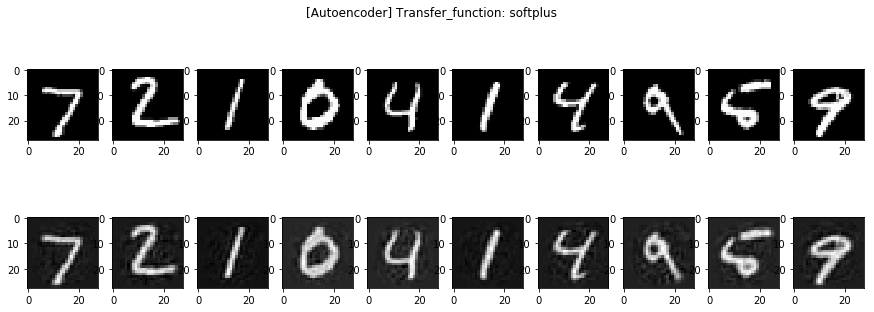

In [10]:
examples_to_show = 10
start_img = 0
idx = range(start_img, start_img + examples_to_show)
X_test_original = mnist.test.images
func_name = str(autoencoder.transfer).split(' ')[1]
suptitle_name = '[Autoencoder] Transfer_function: %s' % (func_name)

reconstructed_images = autoencoder.reconstruct(X_test[idx, :])
f, a = plt.subplots(2, examples_to_show, figsize=(15, 5))
for i in range(start_img, examples_to_show):
    a[0][i].imshow(np.reshape(X_test_original[i, :], (28, 28)), cmap=plt.get_cmap('gray'))
    a[1][i].imshow(np.reshape(reconstructed_images[i, :], (28, 28)), cmap=plt.get_cmap('gray'))
plt.suptitle(suptitle_name)
f.show()
# f.savefig('figures/testImage_%s_dropout_%.3f.png' % (func_name, autoencoder.dropout_probability))

In [11]:
autoencoder.weights

{'b1': <tensorflow.python.ops.variables.Variable at 0x7f870303cef0>,
 'b2': <tensorflow.python.ops.variables.Variable at 0x7f870303cf98>,
 'w1': <tensorflow.python.ops.variables.Variable at 0x7f87028655f8>,
 'w2': <tensorflow.python.ops.variables.Variable at 0x7f870303cf28>}

In [12]:
encoder_weight = autoencoder.sess.run(autoencoder.weights['w1'])
decoder_weight = autoencoder.sess.run(autoencoder.weights['w2'])

In [13]:
encoder_weight[0, :]

array([-0.09231877,  0.09967366, -0.01641758,  0.01060186, -0.02272796,
        0.02249272, -0.0662045 ,  0.03472528, -0.06978319,  0.06475462,
        0.01452363, -0.03280871,  0.17520136,  0.05391125, -0.05472264,
       -0.05812623, -0.09157278, -0.07559745, -0.07497767, -0.03260956,
       -0.01692577,  0.04364505,  0.13730568, -0.08731487,  0.10155269,
       -0.03360949,  0.05524816, -0.07227597,  0.00196469, -0.158906  ,
       -0.03111699,  0.02453419,  0.03637172, -0.06326899,  0.11380568,
       -0.04235907,  0.07815871, -0.01418097,  0.00376919,  0.016676  ,
       -0.0614754 ,  0.00390404,  0.02430663,  0.0162656 , -0.04331323,
        0.04632445, -0.00273848, -0.00598556,  0.00258554,  0.02870885,
        0.01471933,  0.07475595,  0.00816096, -0.10610297,  0.02809819,
       -0.07158083,  0.04639002,  0.01292539,  0.04513199,  0.16982935,
       -0.04841771,  0.03594122, -0.08968025, -0.02407951, -0.0119749 ,
        0.02752497,  0.08931497,  0.03009948, -0.01874588, -0.01

In [14]:
decoder_weight[:, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [15]:
encoder_bias = autoencoder.sess.run(autoencoder.weights['b1'])
decoder_bias = autoencoder.sess.run(autoencoder.weights['b2'])

In [16]:
encoder_bias

array([ 0.14010444,  0.11863419,  0.17658581, -0.02116881,  0.24345547,
        0.12553264,  0.10869458,  0.09007729,  0.05424846,  0.12086575,
        0.2024883 , -0.0221137 ,  0.20162956,  0.18497823,  0.11775326,
        0.19327661,  0.13620622,  0.01266573,  0.12545742,  0.22731075,
        0.14614697,  0.10045377,  0.15734352,  0.08440252,  0.06769248,
        0.12358562,  0.07398703,  0.16369906,  0.14236668,  0.11287011,
        0.12299369,  0.03173862,  0.00840163,  0.10630549,  0.15982321,
        0.12587325,  0.10677639,  0.1345547 ,  0.21538892,  0.08293141,
        0.16991924,  0.14165591,  0.1130832 ,  0.23137408, -0.00181279,
        0.11860269,  0.00991855,  0.19207893,  0.20496936,  0.15244858,
        0.12228639,  0.16224961,  0.16980813,  0.11482239,  0.16419442,
        0.03691467,  0.15241002,  0.14401108,  0.18820898,  0.11383815,
        0.11904952,  0.15649362,  0.16037901,  0.13444054, -0.01562306,
        0.15347643,  0.23542279,  0.21054998,  0.01854858,  0.12

In [17]:
decoder_bias

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         7.73656284e-05,  -2.57974170e-04,  -7.69120161e-05,
        -6.58657809e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -3.17062484e-04,
        -3.17765138e-04,  -9.75267205e-04,  -2.19824468e-03,
        -1.85586978e-03,  -1.46738591e-03,  -1.82089605e-03,
        -3.98624502e-03,  -3.63991270e-03,  -2.10497761e-03,
        -2.05411995e-03,  -4.44720406e-03,  -6.64641056e-03,
        -5.16251614e-03,  -1.71345146e-03,  -1.74479163e-03,
        -1.19320257e-03,

In [18]:
encoder_bias.shape

(200,)

In [19]:
decoder_bias.shape

(784,)